This notebook provides an example of how to use the `poopy` package to access live event duration monitoring data provided by English water companies.

First, we import the libraries we need.

In [1]:
from poopy.companies import ThamesWater

# To help demonstrate the package
import json
import os
import time

The intended way to access active EDM data is by instantiating a `WaterCompany` object, which corresponds to the EDM sensor network maintained by a specific water comapny. When initialising the object, it is populated with all of the active (i.e., _transmitting_) EDM monitors maintained by Thames Water. However, we do not create a `WaterCompany` object directly. Instead, each water company defines a sub-class of a `WaterCompany` object. This is because each company transmits their data via different APIs and so the data is accessed in slightly different ways. However, this is all done 'behind the scenes', so they are all interacted with in the exact same way. The only difference is the name of the class. Lets have a look at the data in Thames Water's active EDM monitors...

To access the Thames Water API you need to specify access codes
for the API which you can obtain [here](https://data.thameswater.co.uk/s/). 
For security reasons, we have not included our access codes in this 
script. Instead, we assume that they have been set as *environment
variables*. If you are running this script on your own machine, you
will need to set these environment variables yourself. 

In [2]:
tw_clientID = os.getenv("TW_CLIENT_ID")
tw_clientSecret = os.getenv("TW_CLIENT_SECRET")

if tw_clientID is None or tw_clientSecret is None:
    raise ValueError(
        "Thames Water API keys are missing from the environment!\n Please set them and try again."
    )

tw = ThamesWater(tw_clientID, tw_clientSecret)

Initialising Thames Water object...
Requesting current status data from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=1000
	No more records to fetch


We can see the names of these monitors by using the `active_monitor_names` attribute

In [3]:
print("-" * 50)
print("Number of active monitors: ", len(tw.active_monitor_names))
print("Active monitor names: ")
for name in tw.active_monitor_names[50:60]: # Select a random sample of 10
    print("\t", name)
print("-" * 50)

--------------------------------------------------
Number of active monitors:  589
Active monitor names: 
	 [Coming Soon] Gordon Road
	 [Coming Soon] Graham Gardens
	 [Coming Soon] Granville Road
	 [Coming Soon] Hammersmith Bridge
	 [Coming Soon] Haslemere STW CSO
	 [Coming Soon] Hattchets Cricklade
	 [Coming Soon] Havelock Road Jnc Clarendon Road
	 [Coming Soon] High Road Loughton
	 [Coming Soon] Home Park Road
	 [Coming Soon] Hull Green (Matching)
--------------------------------------------------


Lets see the current status of a random monitor in the network. Lets extract a random monitor in the network

In [4]:
print("Selecting an arbitrary monitor...")
name = tw.active_monitor_names[359]
print("Monitor name: ", name)

Selecting an arbitrary monitor...
Monitor name:  Kempsford


The monitors are stored in a `Dictionary` of `Monitor` objects, which can be accessed using the `monitors` attribute. We now extract the `Monitor` object corresponding to the name we have just extracted. We can then use the `print_status` method to print the current status of the monitor.

In [5]:
monitor = tw.active_monitors[name]
monitor.print_status()


        
        --------------------------------------
        Event Type: Not Discharging
        Site Name: Kempsford
        Permit Number: CATM.3520
        OSGB Coordinates: (416570, 197540)
        Receiving Watercourse: Dudgrove Stream
        Start Time: 2023-12-02 17:00:00
        End Time: Ongoing
        Duration: 44722.23 minutes
        


Each `Monitor` stores the `WaterCompany` object which contains the monitor. For example, the `Monitor` we have just extracted is maintained by the following `WaterCompany` object:

In [6]:
print("Monitor maintained by: ", monitor.water_company.name)

Monitor maintained by:  ThamesWater


We can also see when the information was last updated by querying the WaterCompany object's timestamp attribute

In [7]:
print("Monitor data last updated: ", monitor.water_company.timestamp)

Monitor data last updated:  2024-01-02 18:22:13.707394


Lets say we think maybe there has been a change in the status of the monitor since the last update. We can use the `WaterCompany`'s `update()` method to update the status of the `Monitor`. Note that this updates all `Monitor`s maintained by the `WaterCompany` object, not just the one we are interested in.

In [8]:
print("... pausing for 5 seconds ...")
time.sleep(5)
print("Updating monitor data...")
monitor.water_company.update()
print("Monitor last updated: ", monitor.water_company.timestamp)

... pausing for 5 seconds ...
Updating monitor data...
Requesting current status data from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=1000
	No more records to fetch
Monitor last updated:  2024-01-02 18:22:19.320699


Note that the timestamp has been updated.

The `current_event` attribute of the `Monitor` object stores an `Event` object that contains specific information. `Event` is a class that contains three sub-classes corresponding to the three different types of status that can be recorded: `Discharge`, `NoDischarge` and `Offline`. The `current_event` attribute will contain an object of one of these three classes, depending on the current status of the monitor.

Lets see what the current status of the event recorded at the monitor is:

In [9]:
print("Extracting current event at monitor...")
event = monitor.current_event
print("Event ongoing? ", event.ongoing)

Extracting current event at monitor...
Event ongoing?  True


Because the event is ongoing it doesn't have an end time, but it does have a start time.
As a result, the `duration` attribute of the `Event` object updates dynamically to show the duration
of the event so far (in minutes). We can see this here.

In [10]:
print("Event start:", event.start_time)
print("Event duration:", event.duration, "minutes")
print("... pausing for 5 seconds ...")
time.sleep(5)
print("Event duration (5 seconds later):", event.duration, "minutes")

Event start: 2023-12-02 17:00:00
Event duration: 44722.322283316666 minutes
... pausing for 5 seconds ...
Event duration (5 seconds later): 44722.405682966666 minutes


Lets query all the CSOs that are currently discharging using the `WaterCompany`'s `discharging_monitors` attribute. This returns a list of `Monitor` objects that are currently discharging. We loop through and print their summaries. Note how the colour of the summary changes depending on the status of the monitor.

In [11]:
print("Extracting all discharging CSOs...")
discharging = tw.discharging_monitors
print("Printing summary of all discharging CSOs...")
for monitor in discharging:
    monitor.print_status()

Extracting all discharging CSOs...
Printing summary of all discharging CSOs...

        
        --------------------------------------
        Event Type: Discharging
        Site Name: Abbess Roding
        Permit Number: CTCR.2034
        OSGB Coordinates: (557580, 211090)
        Receiving Watercourse: Coopers Brook
        Start Time: 2023-12-03 09:30:00
        End Time: Ongoing
        Duration: 43732.41 minutes
        

        
        --------------------------------------
        Event Type: Discharging
        Site Name: Abingdon
        Permit Number: CTCR.1804
        OSGB Coordinates: (449330, 195090)
        Receiving Watercourse: Odhay Hill Ditch
        Start Time: 2024-01-01 11:45:00
        End Time: Ongoing
        Duration: 1837.41 minutes
        

        
        --------------------------------------
        Event Type: Discharging
        Site Name: Aldermaston
        Permit Number: TEMP.2345
        OSGB Coordinates: (459120, 165510)
        Receiving Wate

Now we want to look at the downstream impact of the current sewage discharges. We do this using the `get_downstream_geojson` method of the `WaterCompany` object. This returns a `GeoJSON` object that contains as line features, the river sections that are downstream of the discharging CSOs. We optionally include the `include_recent_discharges` argument, which defaults to `False`. If this is `True`, then the `GeoJSON` object will also track the impact of discharges that are no longer ongoing but have occurred in the last 48 hours. 

In [12]:
geojson = tw.get_downstream_geojson(include_recent_discharges = True)

This is a MultiLineString `GeoJSON` object, which means that each feature is a line, and each line is made up of multiple points. For example, lets loop through them and plot them now. The coordinates are stored in the `coordinates` attribute of the `GeoJSON` object. 

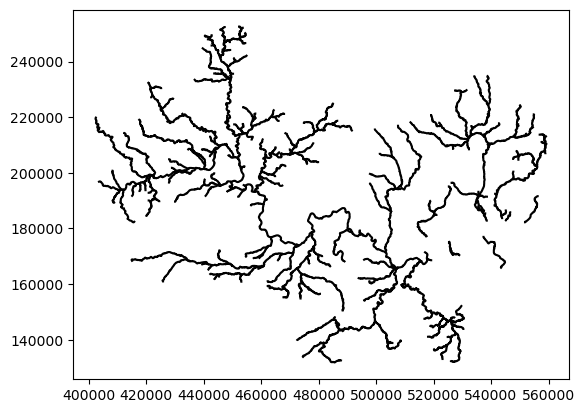

In [13]:
import matplotlib.pyplot as plt
for line in geojson.coordinates:
    x = [c[0] for c in line]
    y = [c[1] for c in line]
    plt.plot(x, y, color="k")

This object can be visualised in python using packages like, for example, geopandas. To use this information in other geospatial software, we can alternatively save the downstream points to file, as shown below. This can be loaded into standard GIS software. The output coordinate system is the British National Grid (epsg:27700).

In [14]:
filename = tw.name+tw.timestamp.strftime("%y%m%d%H%M%S")+".geojson"
with open(filename, "w") as f:
    print(f"Saving to file: {filename}")
    json.dump(geojson, f)

Saving to file: ThamesWater240102182219.geojson


To visualise the current status of all monitors at once and also the downstream impact you can use the `plot_current_status` function. The rivers are shown in the background. EDM monitors are shown as crosses. Red indicates an actively discharging monitor, orange, in the last 48 hours, grey is offline and green is not discharging. The downstream impact is shown as a brown line. 

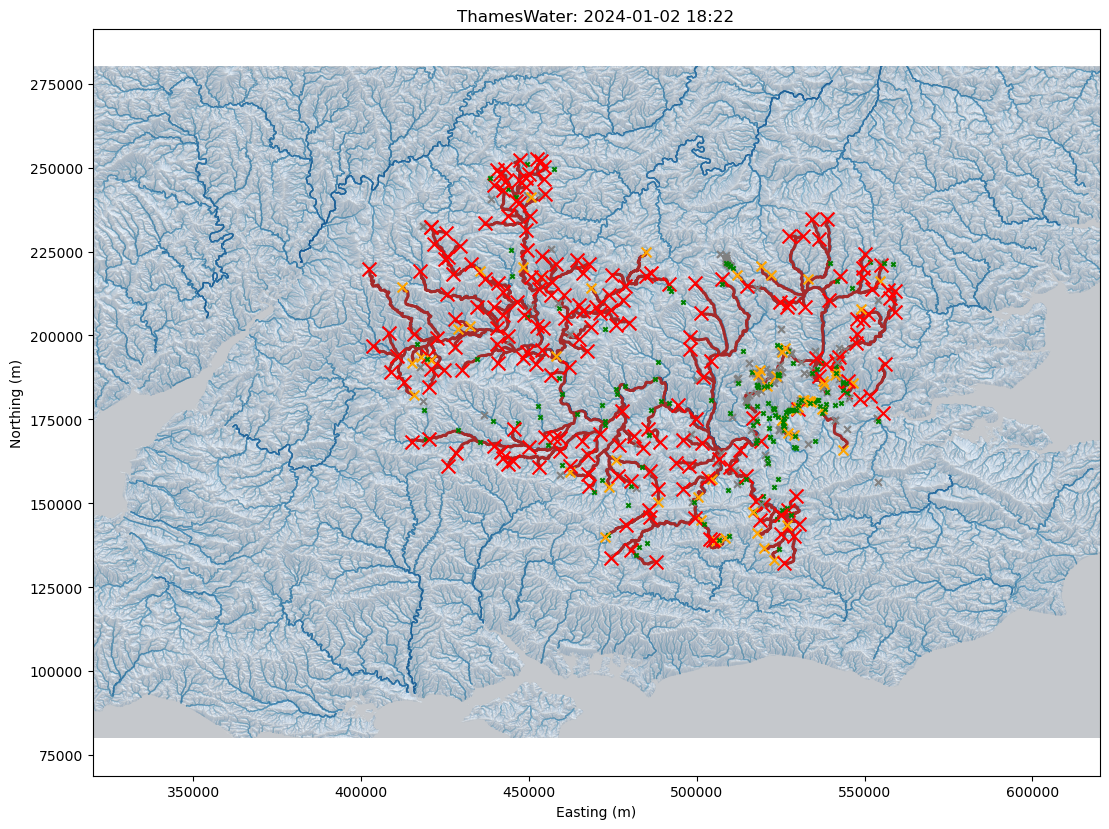

In [15]:
tw.plot_current_status()

We sometimes may want more information on the downstream impact rather than whether it just is or isn't downstream of a CSO. For example, we may want to know how many upstream there are, and how many there are _per $km^2$ upstream area_. Additionally, we might want to know which upstream CSOs are the source of pollution for any point in the network. We can return this information, as GeoJSON feature using the `get_downstream_info_geojson()` method. For example: 

In [16]:
info_geojson = tw.get_downstream_info_geojson(include_recent_discharges=True)

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/d8_accumulator.py:240: UserWarning: 
Profile is empty. Returning empty arrays
  warnings.warn("\nProfile is empty. Returning empty arrays")


This `FeatureCollection` object contains a list of `Features` each of which is a `Point` geometry that contains `properties` and a `geometry`. The properties contain the information we want and the `geometry` tells us where the point is. For example, lets look at the first feature:

In [17]:
print(info_geojson.features[0].properties)
print(info_geojson.features[0].geometry)

{'number_upstream_CSOs': 1.0, 'number_CSOs_per_km2': 0.1393242772553118, 'CSOs': ['Byfield']}
{"coordinates": [452475.0, 252625.0], "type": "Point"}


Lets see what these properties look like spatially:

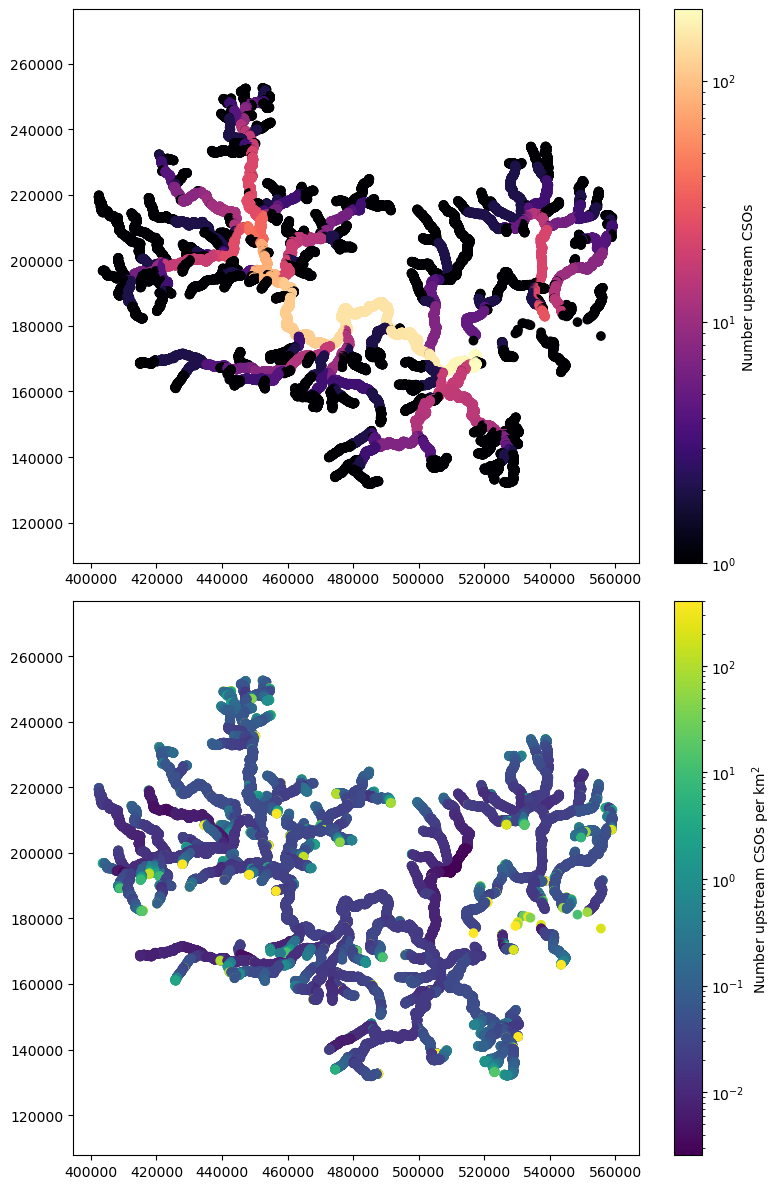

In [40]:
from matplotlib.colors import LogNorm

x, y, num_upst, num_upst_per_km2 = [], [], [], []
for feature in info_geojson.features:
    x.append(feature.geometry.coordinates[0])
    y.append(feature.geometry.coordinates[1])
    num_upst.append(feature.properties["number_upstream_CSOs"])
    num_upst_per_km2.append(feature.properties["number_CSOs_per_km2"])

plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.scatter(x, y, c=num_upst, norm=LogNorm(), cmap="magma")
plt.ylabel("Northing (m)")
plt.axis("equal")
cb = plt.colorbar()
cb.set_label("Number upstream CSOs")
plt.subplot(2, 1, 2)
plt.scatter(x, y, c=num_upst_per_km2, norm=LogNorm(), cmap="viridis")
plt.axis("equal")
cb = plt.colorbar()
cb.set_label("Number upstream CSOs per km$^2$")
plt.xlabel("Easting (m)")
plt.tight_layout()
plt.show()

Like the other GeoJSON objet we can save this to file where it can be loaded into GIS software.

In [18]:
filename = tw.name + tw.timestamp.strftime("%y%m%d%H%M%S") + "_info.geojson"
with open(filename, "w") as f:
    print(f"Saving to file: {filename}")
    json.dump(geojson, f)

Saving to file: ThamesWater240102182219_info.geojson
